In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary

In [20]:
BATCH_SIZE = 32
transform = transforms.Compose([transforms.ToTensor()])

mnist_trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_trainloader = torch.utils.data.DataLoader(mnist_trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=1)

mnist_testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
mnist_testloader = torch.utils.data.DataLoader(mnist_testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=1)

print(mnist_trainset)
print(mnist_testset)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )
Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
           )


[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Train - image batch dimensions: torch.Size([32, 1, 28, 28])
Train - image label dimensions: torch.Size([32])


[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Test - image batch dimensions: torch.Size([32, 1, 28, 28])
Test - image label dimensions: torch.Size([32])
(3, 122, 242)
(122, 242, 3)


[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


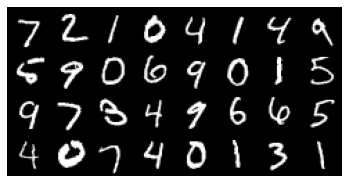

In [21]:
import matplotlib.pyplot as plt
import numpy as np

mnist_dataiter = iter(mnist_trainloader)
images, labels = mnist_dataiter.next()

# print(images.shape)
for images, labels in mnist_trainloader:
    print("Train - image batch dimensions:", images.shape)
    print("Train - image label dimensions:", labels.shape)
    break

# print(labels.shape)
for images, labels in mnist_testloader:
    print("Test - image batch dimensions:", images.shape)
    print("Test - image label dimensions:", labels.shape)
    break

images_grid = torchvision.utils.make_grid(images)
print((images_grid.numpy()).shape)
# print(np.transpose(images_grid.numpy(), (1, 2, 0)))
print(np.transpose(images_grid.numpy(), (1, 2, 0)).shape)
plt.imshow(np.transpose(images_grid.numpy(), (1, 2, 0)))
plt.axis('off')
plt.show()

In [22]:
class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()

        self.convlayer = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
        self.fclayer1 = nn.Linear(26 * 26 * 32, 128)
        self.fclayer2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.convlayer(x)        # input: 32x1x28x28    -> output: 32x32x26x26
        x = F.relu(x)
        x = x.flatten(start_dim = 1) # input: 32x32x26x26   -> output: 32x(32*26*26)
        x = self.fclayer1(x)         # input: 32x(32*26*26) -> output: 32x128
        x = F.relu(x)
        logits = self.fclayer2(x)    # input: 32x128        -> output: 32x10 (32 images, 10 classes)
        out = F.softmax(logits, dim=1)
        return out

model = SimpleModel()
for images, labels in mnist_trainloader:
    print("batch size:", images.shape)
    out = model(images)
    print(out.shape)
    break

summary(model, input_size=(1,28,28))

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


batch size: torch.Size([32, 1, 28, 28])
torch.Size([32, 10])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
            Linear-2                  [-1, 128]       2,769,024
            Linear-3                   [-1, 10]           1,290
Total params: 2,770,634
Trainable params: 2,770,634
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.17
Params size (MB): 10.57
Estimated Total Size (MB): 10.74
----------------------------------------------------------------


In [23]:
def compute_stat(outputs, labels, stats):
    _, preds = torch.max(outputs, 1)
    stats['n_corr'] += torch.sum(preds == labels).item()
    stats['n'] += torch.numel(labels)

    return stats

def train_model(model, criterion, optimizer, trainloader, device, num_epochs=25):
  epoch_stat = {'n_corr': 0, 'n': 0}

  for epoch in range(num_epochs):
      train_running_loss = 0.0
      train_acc = 0.0

      model.train()  # Set model to training mode

      for i, (images, labels) in enumerate(trainloader): # training step / batch 하나씩 처리하는 for문
          
          images = images.to(device) # cpu에서 gpu로 data 넘김
          labels = labels.to(device)
          optimizer.zero_grad() # grdient 초기 상태로

          outputs = model(images) # feed forward
          loss = criterion(outputs, labels) # 오차
          loss.backward() # backprop : loss에 따라 gradient가 계산됨
          optimizer.step() # weight 값들이 조절됨

          train_running_loss += loss.detach().item() # 에러값이 어떻게 계산되었는지 확인하기위해 더하주고 있음
          epoch_stat = compute_stat(outputs, labels, epoch_stat) # 얼마나 정답인지 등 stat 표기.
      
      model.eval() # evaluation(평가) mode로 전환
      print('Epoch: %d | Loss: %.4f | Train Accuracy: %.2f' \
            %(epoch, train_running_loss / i, epoch_stat['n_corr'] / epoch_stat['n'] * 100)) 
      
  return model

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model = SimpleModel()
model = model.to(device) # cpu에서 gpu로 data 넘김

criterion = nn.CrossEntropyLoss() # loss function
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9) # optimization
num_epochs = 5

model = train_model(model, criterion, optimizer, mnist_trainloader, device, num_epochs)

cpu


[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Epoch: 0 | Loss: 1.6689 | Train Accuracy: 79.30


[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Epoch: 1 | Loss: 1.5890 | Train Accuracy: 83.28


[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Epoch: 2 | Loss: 1.5069 | Train Accuracy: 87.36


[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Epoch: 3 | Loss: 1.5145 | Train Accuracy: 89.20


[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Epoch: 4 | Loss: 1.5265 | Train Accuracy: 90.07


In [24]:
model.eval() # Set model to evaluate mode

test_stat = {'n_corr': 0, 'n': 0}
for i, (images, labels) in enumerate(mnist_testloader, 0):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    test_stat = compute_stat(outputs, labels, test_stat)
        
print('Test Accuracy: %.2f'%( test_stat['n_corr'] / test_stat['n'] * 100))

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Test Accuracy: 94.03


----------

In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from torchsummary import summary

In [26]:
BATCH_SIZE = 64

transform = transforms.Compose([transforms.ToTensor()])

cifar_trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
cifar_trainloader = torch.utils.data.DataLoader(cifar_trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=1)

cifar_testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
cifar_testloader = torch.utils.data.DataLoader(cifar_testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=1)

Files already downloaded and verified
Files already downloaded and verified


[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


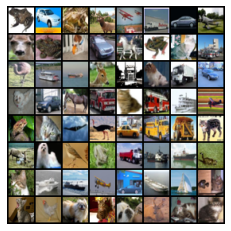

Train - image batch dimensions: torch.Size([64, 3, 32, 32])
Train - image label dimensions: torch.Size([64])


[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Test - image batch dimensions: torch.Size([64, 3, 32, 32])
Test - image label dimensions: torch.Size([64])


[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


In [27]:
import matplotlib.pyplot as plt
import numpy as np

dataiter = iter(cifar_trainloader) # get some random training images
images, labels = dataiter.next()

images_grid = torchvision.utils.make_grid(images) # show images
plt.imshow(np.transpose(images_grid.numpy(), (1, 2, 0)))
plt.axis('off')
plt.show()

for images, labels in cifar_trainloader:
    print("Train - image batch dimensions:", images.shape)
    print("Train - image label dimensions:", labels.shape)
    break

for images, labels in cifar_testloader:
    print("Test - image batch dimensions:", images.shape)
    print("Test - image label dimensions:", labels.shape)
    break

In [28]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model_ft = models.resnet18(pretrained=True) # load the existing model (Resnet18) / pretrained model: 선 학습된 weight 가져온다.
model_ft = model_ft.to(device)
print(model_ft)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [29]:
summary(model_ft, input_size=(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 6

In [30]:
print(model_ft.fc)

fc_num_in_fts = model_ft.fc.in_features
fc_num_out_fts = model_ft.fc.out_features
print('LAST - fc: ', fc_num_in_fts, fc_num_out_fts)

model_ft.fc = nn.Linear(fc_num_in_fts, 10)
model_ft = model_ft.to(device)
summary(model_ft, input_size=(3,32,32))

Linear(in_features=512, out_features=1000, bias=True)
LAST - fc:  512 1000
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13        

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

criterion_ft = nn.CrossEntropyLoss() # loss function
optimizer_ft = optim.Adam(model_ft.parameters(), lr=1e-4) # optimization

model_ft = train_model(model_ft, criterion_ft, optimizer_ft, cifar_trainloader, device, num_epochs=5)

In [ ]:
test_stat = {'n_corr': 0, 'n': 0}
for i, (images, labels) in enumerate(cifar_testloader, 0):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model_ft(images)
    test_stat = compute_stat(outputs, labels, test_stat)
        
print('Test Accuracy: %.2f'%( test_stat['n_corr'] / test_stat['n'] * 100))

In [35]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model_ft2 = models.resnet18(pretrained=True) # load the existing model (Resnet18), use weights from ImageNet dataset
model_ft2 = model_ft2.to(device)

print(model_ft2.conv1)

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)


In [36]:
conv1_num_in_fts2 = model_ft2.conv1.in_channels
conv1_num_out_fts2 = model_ft2.conv1.out_channels
print('FIRST - conv1 : ', conv1_num_in_fts2, conv1_num_out_fts2)

fc_num_in_fts2 = model_ft2.fc.in_features
fc_num_out_fts2 = model_ft2.fc.out_features
print('LAST - fc: ', fc_num_in_fts2, fc_num_out_fts2)

FIRST - conv1 :  3 64
LAST - fc:  512 1000


In [38]:
model_ft2.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=7, stride=1, padding=3, bias=False)

model_ft2.fc = nn.Linear(fc_num_in_fts2, 10)  # 10 classes

model_ft2 = model_ft2.to(device)
summary(model_ft2, input_size=(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 28, 28]           3,136
       BatchNorm2d-2           [-1, 64, 28, 28]             128
              ReLU-3           [-1, 64, 28, 28]               0
         MaxPool2d-4           [-1, 64, 14, 14]               0
            Conv2d-5           [-1, 64, 14, 14]          36,864
       BatchNorm2d-6           [-1, 64, 14, 14]             128
              ReLU-7           [-1, 64, 14, 14]               0
            Conv2d-8           [-1, 64, 14, 14]          36,864
       BatchNorm2d-9           [-1, 64, 14, 14]             128
             ReLU-10           [-1, 64, 14, 14]               0
       BasicBlock-11           [-1, 64, 14, 14]               0
           Conv2d-12           [-1, 64, 14, 14]          36,864
      BatchNorm2d-13           [-1, 64, 14, 14]             128
             ReLU-14           [-1, 64,

In [ ]:
criterion_ft2 = nn.CrossEntropyLoss() # loss function
optimizer_ft2 = optim.Adam(model_ft2.parameters(), lr=1e-3) # optimization

model_ft2 = train_model(model_ft2, criterion_ft2, optimizer_ft2, mnist_trainloader, device, num_epochs=5)

In [ ]:
test_stat = {'n_corr': 0, 'n': 0}
for i, (images, labels) in enumerate(mnist_testloader, 0):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model_ft2(images)
    test_stat = compute_stat(outputs, labels, test_stat)
        
print('Test Accuracy: %.2f'%( test_stat['n_corr'] / test_stat['n'] * 100))